In [22]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from dataset_eval import Dataset
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import numpy as np

from time import time
from visdom import Visdom
import copy

num_classes = 7
batch_size = 32
feature_extract = False
pretrained = False
input_size = 224

classes_name = ['sea', 'green', 'city', 'house_building', 'face', 'house_indoor', 'office']
BASE_DIR = '/home/jun/Github/BoVW/dataset/'

confusion_matrix = torch.zeros(num_classes, num_classes)

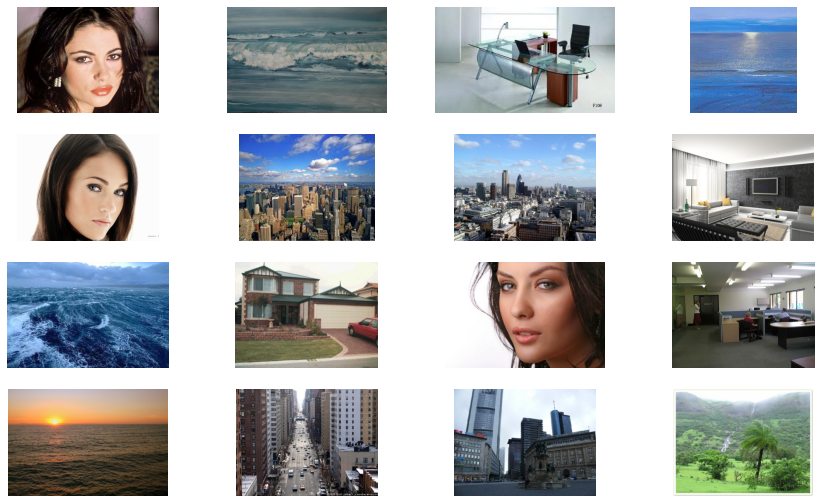

In [8]:
import random
from PIL import Image 

images = []

for folder in os.listdir(BASE_DIR + 'test'):
    for image in os.listdir(BASE_DIR + 'test' + '/' + folder):
        images.append(os.path.join(BASE_DIR + 'test', folder, image))

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(16):
    n += 1
    random_img = random.choice(images)
    imgs = cv2.imread(random_img)
    imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, n)
    plt.axis('off')
    plt.imshow(imgs)

plt.show()

In [23]:
def confusion_matrix_plot(cm, classes, normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [24]:
def eval_model(model, dataloaders, test_ds):
    model.eval() 
    
    running_loss = 0.0
    running_corrects = 0
    
    count = 0 
    
    # Iterate over data.
    for step, (inputs, labels) in enumerate(dataloaders):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        # loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels)
        count = count + 1
        
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

#     print(len(train_ds.image_list))
#     print(confusion_matrix)
#     print(confusion_matrix.diag()/confusion_matrix.sum(1))
    
    confusion_matrix_plot(confusion_matrix.numpy(), test_ds.classes_name)  
    
    return running_corrects/len(test_ds.image_list)

['sea', 'green', 'city', 'house_building', 'face', 'house_indoor', 'office']
Normalized confusion matrix
[[0.9        0.06666667 0.03333333 0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.1        0.1        0.8        0.         0.         0.
  0.        ]
 [0.         0.         0.06666667 0.93333333 0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.43333333
  0.56666667]
 [0.         0.         0.03333333 0.         0.         0.03333333
  0.93333333]]
tensor(0.8571, device='cuda:0')


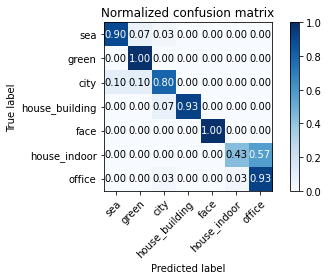

In [25]:
test_ds = Dataset(BASE_DIR)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

model = models.resnet18(pretrained=pretrained).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)

# model =  torch.nn.DataParallel(model).cuda()
model.cuda()

# Load model trained
model.load_state_dict(torch.load('./model/net11-0.050.pth'))

loss_fn = torch.nn.CrossEntropyLoss()
acc = eval_model(model, test_dl, test_ds)
print(acc)


In [26]:
sample_test_img = cv2.imread(BASE_DIR + 'test/office/office_test-001.jpg')
sample_test_img = cv2.cvtColor(sample_test_img, cv2.COLOR_BGR2RGB)

test_img = cv2.resize(sample_test_img, (input_size,input_size), interpolation=cv2.INTER_CUBIC)

test_img = np.moveaxis(test_img,2,0)
test_img = torch.FloatTensor(test_img).cuda().unsqueeze(0)
print(test_img.shape)

outputs = model(test_img)
nn.Softmax(dim=1)(outputs)
# print(model)
# print(outputs.shape)
print(outputs)
_, preds = torch.max(outputs, 1)
print(classes_name[preds])

torch.Size([1, 3, 224, 224])
tensor([[-1.0304, -3.6520, -2.0762, -2.6209, -0.5661,  2.6579,  4.6969]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
office


In [27]:
# Compare agaist other images in the predicted class 
pred_file_ls = os.listdir(os.path.join(BASE_DIR+'train', classes_name[preds]))

sift = cv2.xfeatures2d.SIFT_create()

kp, des = sift.detectAndCompute(sample_test_img, None)

match_rank = []

for idx in tqdm(range(len(pred_file_ls))):
    img = cv2.imread(BASE_DIR + 'train/' + classes_name[preds] + '/' + pred_file_ls[idx])
    kp_check, des_check = sift.detectAndCompute(img, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des, des_check, k=2)

    # Apply ratio test
    good_and_second_good_match_list = []
    for m in matches:
        if m[0].distance/m[1].distance < 0.5:
            good_and_second_good_match_list.append(m)
    good_match_arr = np.asarray(good_and_second_good_match_list)
    
    match_rank.append((idx,len(good_match_arr)))

100%|██████████| 140/140 [00:20<00:00,  6.97it/s]


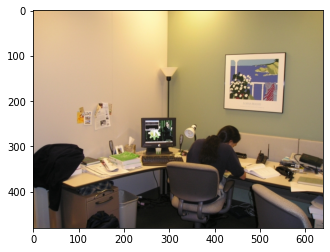

In [28]:
np.flip(sample_test_img, axis=-1) 
plt.imshow(sample_test_img)
plt.show()

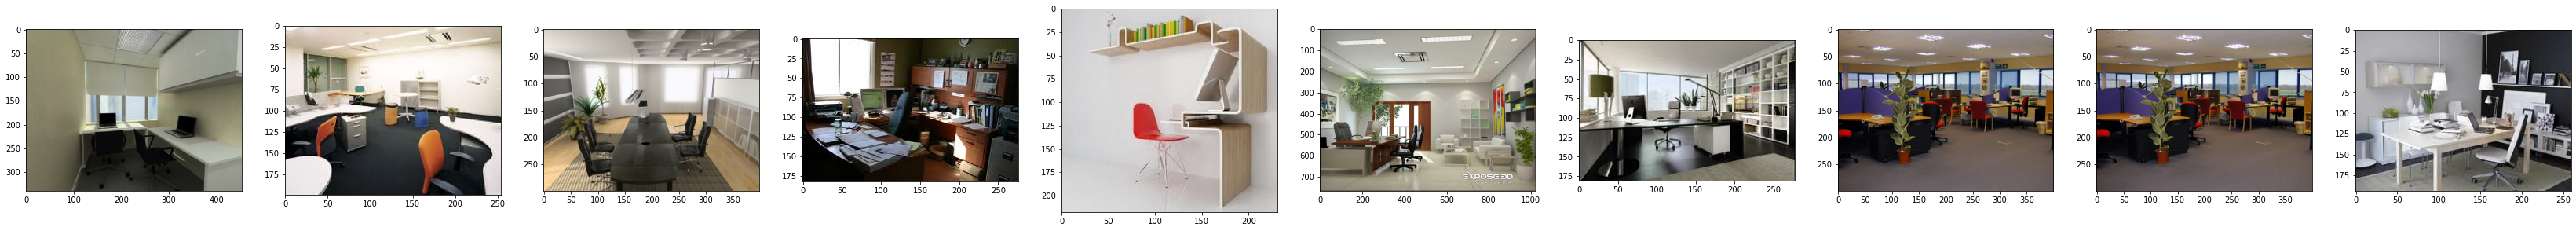

In [32]:
match_rank = np.asarray(match_rank)
match_rank = match_rank[match_rank[:,1].argsort()]

# print(match_rank)

# Top-k ranking
k = 10
top_k_rank = match_rank[len(pred_file_ls)- k - 1:,0]

# print(top_k_rank)

fig = plt.figure(figsize=(64,256))
columns = k + 1
rows = 1
for i in range(1,k+1):
    img = cv2.imread(BASE_DIR + 'train/' + classes_name[preds] + '/' + pred_file_ls[top_k_rank[i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()